In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from itertools import product

from skimage import io, color, exposure, transform, img_as_float32
import skimage
from sklearn import preprocessing

from dask import bag, diagnostics
from scipy import stats

from pathlib import Path
import os, sys

sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

import umap
import umap.plot

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Import normal peripheral blood cell dataset

In [3]:
path_name = '../../data/PBC_dataset_normal_df_resize_luminance.csv'
path = Path(path_name)
df = pd.read_csv(path_name)
df.head()

,img_paths,id,label,height,width,mean_brightness,mean_luminance
0,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,225079,MO,363,360,196.225564,0.756902
1,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,582430,MO,363,360,196.672727,0.757366
2,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,436409,MO,363,360,204.348235,0.797640
3,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,648815,MO,363,360,199.038259,0.770929
4,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,668574,MO,363,360,191.020018,0.734784


In [4]:
classes = df['label'].unique()
classes

array(['MO', 'ERB', 'PLATELET', 'BA', 'IG', 'SNE', 'LY', 'EO'],
      dtype=object)

In [5]:
le = preprocessing.LabelEncoder()
target = le.fit_transform(df.label)
le.classes_

array(['BA', 'EO', 'ERB', 'IG', 'LY', 'MO', 'PLATELET', 'SNE'],
      dtype=object)

## Import images and store as an array of arrays

In [6]:
dfile_bag = bag.from_sequence(df.img_paths.to_list()).map(leuko.load_image, 
                                                          as_grey=True, 
                                                          rescale=0.5)

In [9]:
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())


[########################################] | 100% Completed |  2min 29.2s


In [10]:
images_flat = images.reshape(images.shape[0], -1)

### UMAP embedding in 2D

In [32]:
%%time
mapper = umap.UMAP(n_neighbors=5, random_state=42, n_jobs=6).fit(images_flat)
embedding = mapper.transform(images_flat)

CPU times: user 4min 6s, sys: 5.53 s, total: 4min 12s
Wall time: 1min


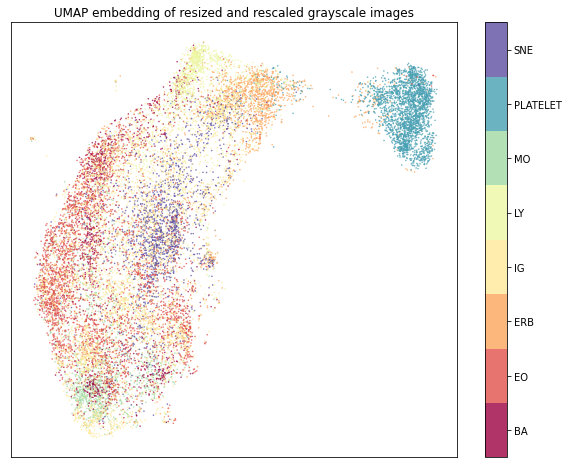

In [33]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(le.classes_)
plt.title('UMAP embedding of resized and rescaled grayscale images');



<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

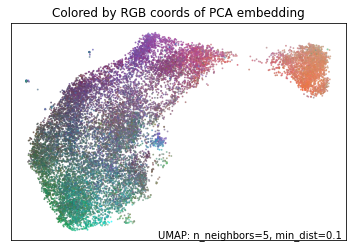

In [34]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

<AxesSubplot:>

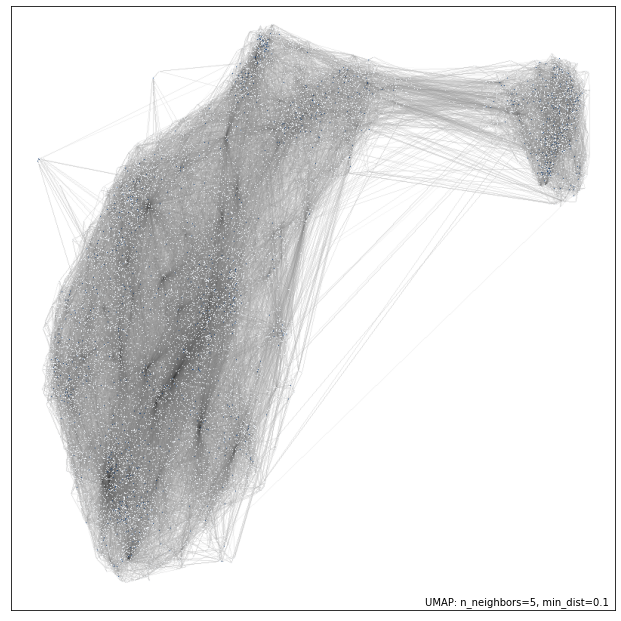

In [39]:
umap.plot.connectivity(mapper, show_points=True)

### Plotting connectivity for small sample

In [35]:
sample = df.groupby('label').sample(n=400)
sample.label.value_counts()

ERB         400
BA          400
LY          400
PLATELET    400
SNE         400
IG          400
EO          400
MO          400
Name: label, dtype: int64

In [36]:
sample_im = images_flat[sample.index]

In [37]:
%%time
mapper_s = umap.UMAP(random_state=42, n_jobs=6).fit(sample_im)
embedding_S = mapper.transform(sample_im)

CPU times: user 3min 12s, sys: 1.86 s, total: 3min 14s
Wall time: 3min 9s


In [90]:
sample['X'] = embedding_S[:, 0]
sample['Y'] = embedding_S[:, 1]

sample2 = sample.sample(frac=0.035)
sample2
paths = sample2.img_paths
x_coord = sample2.X.to_list()
y_coord = sample2.Y.to_list()

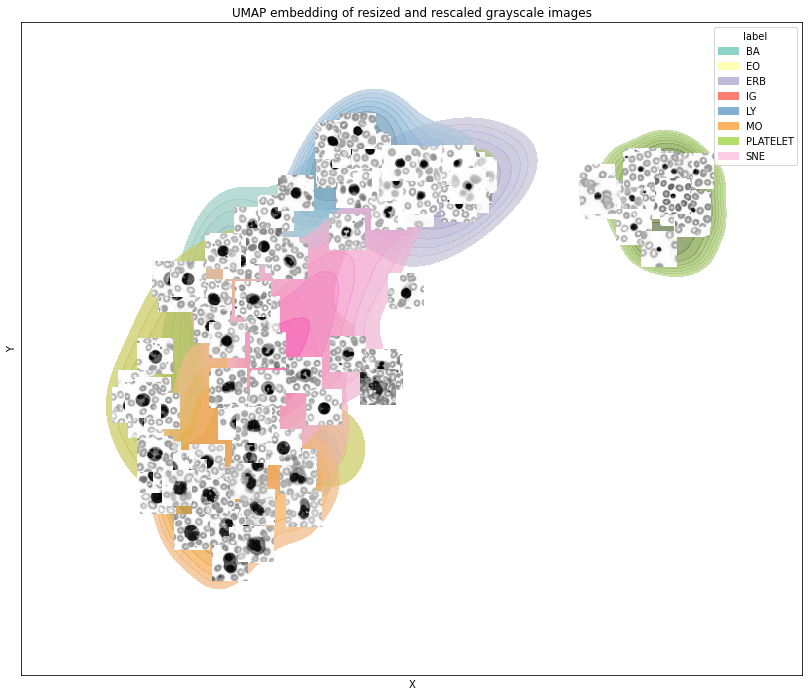

In [96]:
fig, ax = plt.subplots(1, figsize=(14, 12))
# plt.scatter(*embedding_S.T, s=200, c=target[sample.index], cmap='Spectral', alpha=0.8)
sns.kdeplot(x=sample.X, y=sample.Y, hue='label', data=sample, shade=True, thresh=0.2, alpha=0.7, palette='Set3')
plt.setp(ax, xticks=[], yticks=[])

# cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(le.classes_)
plt.title('UMAP embedding of resized and rescaled grayscale images')


def getImage(path):
    return OffsetImage(leuko.load_image(path, as_grey=True, rescale=0.1),
                      cmap='gray')

for x, y, path in zip(x_coord, y_coord, paths):
    ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
    ax.add_artist(ab)

/home/marie-anne/anaconda3/envs/DStest/lib/python3.9/site-packages/umap/plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

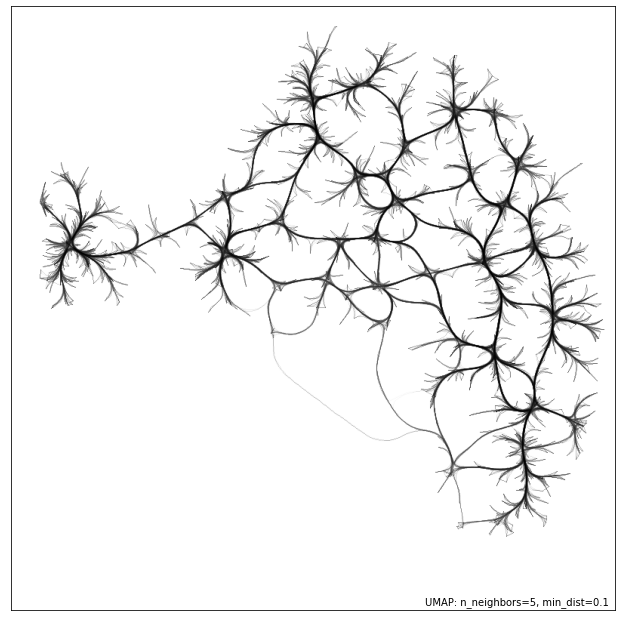

In [31]:
umap.plot.connectivity(mapper_s, edge_bundling='hammer')

## Embedding with label

In [82]:
%%time
embedding_lab = umap.UMAP().fit_transform(images_flat, y=target)

CPU times: user 13min 3s, sys: 8.54 s, total: 13min 11s
Wall time: 2min 15s


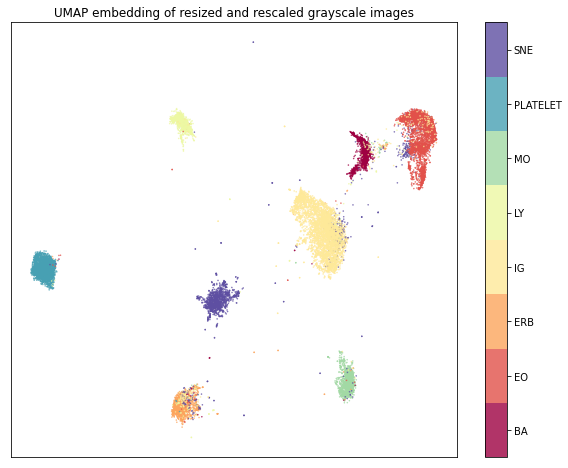

In [83]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_lab.T, s=0.3, c=target, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(le.classes_)
plt.title('UMAP embedding of resized and rescaled grayscale images');